c:\Users\rifat\miniconda3\envs\mlweb\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rifat\miniconda3\envs\mlweb\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\rifat\AppData\Local\Temp\ipykernel_21156\3011603649.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.97      0.98       548
   PNEUMONIA       0.97      0.99      0.98       427
     UNKNOWN       1.00      1.00      1.00       135
TUBERCULOSIS       0.99      0.99      0.99       417

    accuracy                           0.98      1527
   macro avg       0.99      0.99      0.99      1527
weighted avg       0.99      0.98      0.98      1527



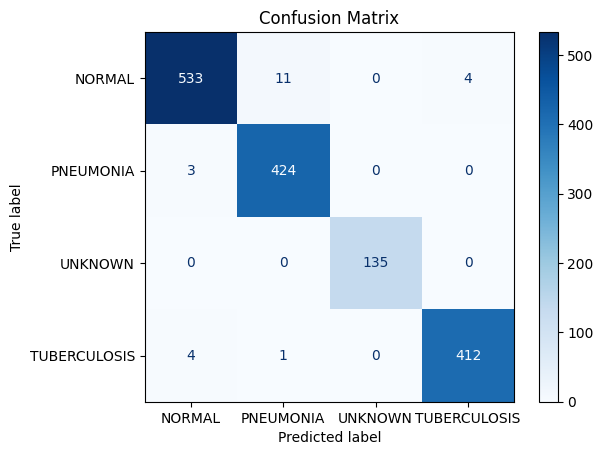

Accuracy: 98.49%
Incorrect predictions saved to incorrect_predictions.csv


In [1]:
import csv
import os
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Load the pretrained ResNet-18 model and modify for 4 classes
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # Modify for 4-class classification

# Load the trained model weights
model.load_state_dict(torch.load('D:/MY_web/portfolio_web_backend-/tuberculosis-pneumonia/Train/model/model_36.pt'))
model.eval()
model.to(device)

# Define test dataset directories
test_dir = r"D:\source\data\data\test"
normal_dir = os.path.join(test_dir, "NORMAL")
pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")
unknown_dir = os.path.join(test_dir, "UNKNOWN")
tuberculosis_dir = os.path.join(test_dir, "TUBERCULOSIS")

# Initialize variables to store results
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels
incorrect_predictions = []  # To store incorrect predictions for saving to CSV

# Helper function to predict a single image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transformations(image)
    image = image.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        predicted_label = output.argmax(dim=1).item()  # Get the class with the highest score
    return predicted_label

# Evaluate a directory of images
def evaluate_images(directory, true_label):
    for image_name in os.listdir(directory):
        if image_name.lower().endswith(('png', 'jpg', 'jpeg', '.bmp')):
            image_path = os.path.join(directory, image_name)
            predicted_label = predict_image(image_path)
            y_true.append(true_label)
            y_pred.append(predicted_label)
            # If the prediction is incorrect, save the result
            if predicted_label != true_label:
                incorrect_predictions.append({
                    "image_name": image_name,
                    "predicted_class": predicted_label,
                    "original_class": true_label
                })

# Evaluate each class
evaluate_images(normal_dir, 0)  # NORMAL = 0
evaluate_images(pneumonia_dir, 1)  # PNEUMONIA = 1
evaluate_images(unknown_dir, 2)  # UNKNOWN = 2
evaluate_images(tuberculosis_dir, 3)  # TUBERCULOSIS = 3

# Convert results to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA", "UNKNOWN", "TUBERCULOSIS"])
print("Classification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA", "UNKNOWN", "TUBERCULOSIS"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Save incorrect predictions to a CSV file
output_csv_path = "incorrect_predictions.csv"
with open(output_csv_path, mode="w", newline="") as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=["image_name", "predicted_class", "original_class"])
    csv_writer.writeheader()
    csv_writer.writerows(incorrect_predictions)

print(f"Incorrect predictions saved to {output_csv_path}")


In [26]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import skimage.transform
from torch import topk

# Define class folder names
class_folders = ['NORMAL', 'PNEUMONIA', 'UNKNOWN', 'TUBERCULOSIS']

# Load incorrect predictions from CSV
incorrect_pred_df = pd.read_csv('incorrect_predictions.csv')  # CSV must have 'image_name', 'original_class', 'predicted_class' columns

# Define a function to get the full path of the image in the test dataset
def get_image_path(original_class, image_name):
    base_dir = r"D:\source\data\data\test"
    if original_class == 0:
        return os.path.join(base_dir, "NORMAL", image_name)
    elif original_class == 1:
        return os.path.join(base_dir, "PNEUMONIA", image_name)
    elif original_class == 2:
        return os.path.join(base_dir, "UNKNOWN", image_name)
    elif original_class == 3:
        return os.path.join(base_dir, "TUBERCULOSIS", image_name)

# Create output directories
output_dir = 'predictions-heatmap'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'correct'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'incorrect'), exist_ok=True)

for class_folder in class_folders:
    os.makedirs(os.path.join(output_dir, 'correct', class_folder), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'incorrect', class_folder), exist_ok=True)

# Load the dataset split
df_dataset_split = pd.read_csv('dataset_splits_with_metadata.csv')

# Filter for sources for each class
NORMAL_sources = df_dataset_split[(df_dataset_split['label'] == 'NORMAL') & (df_dataset_split['split'] == 'test')]['source'].unique()
PNEUMONIA_sources = df_dataset_split[(df_dataset_split['label'] == 'PNEUMONIA') & (df_dataset_split['split'] == 'test')]['source'].unique()
UNKNOWN_sources = df_dataset_split[(df_dataset_split['label'] == 'UNKNOWN') & (df_dataset_split['split'] == 'test')]['source'].unique()
TUBERCULOSIS_sources = df_dataset_split[(df_dataset_split['label'] == 'TUBERCULOSIS') & (df_dataset_split['split'] == 'test')]['source'].unique()



# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

display_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

# Load the model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # Modify for 4-class classification
model.load_state_dict(torch.load('D:/MY_web/portfolio_web_backend-/tuberculosis-pneumonia/Train/model/model_36.pt'))
model.cuda()
model.eval()

# Hook for extracting features
class SaveFeatures():
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

# Function to generate Class Activation Map (CAM)
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

# Extract weights for CAM
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

# Process each prediction (correct and incorrect)
for _, row in incorrect_pred_df.iterrows():
    image_name = row['image_name']
    original_class = row['original_class']
    predicted_class = row['predicted_class']

    # Load the image
    image_path = get_image_path(original_class, image_name)
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    image = Image.open(image_path)
    
    # Preprocess the image
    tensor = preprocess(image)
    prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

    # Set up the hook for the final layer
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)

    # Run prediction
    prediction = model(prediction_var)
    pred_probabilities = F.softmax(prediction, dim=1).data.squeeze()
    activated_features.remove()

    # Get the top predicted class index
    top_class_idx = topk(pred_probabilities, 1)[1].item()

    # Generate Grad-CAM for the top predicted class
    overlay = getCAM(activated_features.features, weight_softmax, top_class_idx)

    # Normalize Grad-CAM heatmap for better visibility
    cam_resized = skimage.transform.resize(overlay[0], tensor.shape[1:3])
    cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())

    # Convert the original image to numpy array
    original_image = np.array(display_transform(image))
    if original_image.ndim == 2:  # Ensure the image is RGB
        original_image = np.stack([original_image] * 3, axis=-1)
    original_image = original_image / 255.0

    # Blend the original image and Grad-CAM
    blended_image = 0.6 * original_image + 0.4 * plt.cm.jet(cam_resized)[:, :, :3]  # Adjust alpha

    # Define the correctness of the prediction
    is_correct = (original_class == top_class_idx)
    status_text = "Correct" if is_correct else f"Incorrect: Predicted {class_folders[top_class_idx]}"

    # Save the plot in the appropriate folder
    save_folder = 'correct' if is_correct else 'incorrect'
    output_folder = os.path.join(output_dir, save_folder, class_folders[original_class])
    os.makedirs(output_folder, exist_ok=True)

    # Create a filename for the combined image
    output_image_path = os.path.join(output_folder, f"{image_name}_combined.png")

    # Create a combined plot with original image and Grad-CAM
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Plot Grad-CAM heatmap
    axes[1].imshow(blended_image)
    axes[1].axis('off')
    axes[1].set_title('Grad-CAM Heatmap')

    # Add text annotations to the plot
    fig.text(0.5, 0.95, f"Original: {class_folders[original_class]}", ha='left', fontsize=12, color='blue')
    fig.text(0.5, 0.88, status_text, ha='center', fontsize=12, color='red' if not is_correct else 'green')
    # Add the source name from the dataset (correct source)
    source_name = df_dataset_split[df_dataset_split['name'] == image_name]['source'].values[0]
    fig.text(0.95, 0.95, f"Source: {source_name}", ha='right', fontsize=12, color='black')

    # Save the figure
    plt.savefig(output_image_path, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"Saved combined image for {image_name} in {output_folder}")



c:\Users\rifat\miniconda3\envs\mlweb\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rifat\miniconda3\envs\mlweb\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\rifat\AppData\Local\Temp\ipykernel_28936\1261035041.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch

Saved combined image for CHNCXR_0239_0.png in predictions-heatmap\incorrect\NORMAL
Saved combined image for IM-0085-0001.jpeg in predictions-heatmap\incorrect\NORMAL
Saved combined image for MCUCXR_0059_0.png in predictions-heatmap\incorrect\NORMAL
Saved combined image for MCUCXR_0094_0.png in predictions-heatmap\incorrect\NORMAL
Saved combined image for Normal-4.png in predictions-heatmap\incorrect\NORMAL
Saved combined image for NORMAL2-IM-0195-0001.jpeg in predictions-heatmap\incorrect\NORMAL
Saved combined image for NORMAL2-IM-0196-0001.jpeg in predictions-heatmap\incorrect\NORMAL
Saved combined image for NORMAL2-IM-0198-0001.jpeg in predictions-heatmap\incorrect\NORMAL
Saved combined image for NORMAL2-IM-0251-0001.jpeg in predictions-heatmap\incorrect\NORMAL
Saved combined image for NORMAL2-IM-0313-0001.jpeg in predictions-heatmap\incorrect\NORMAL
Saved combined image for NORMAL2-IM-0319-0001.jpeg in predictions-heatmap\incorrect\NORMAL
Saved combined image for NORMAL2-IM-0335-000

In [34]:
# Define a function to get two random correct image names and paths from each source
def get_correct_images_from_source(label, source, num_images=2):
    # Get all valid images for the given label and source
    valid_images = df_dataset_split[
        (df_dataset_split['label'] == label) &
        (df_dataset_split['split'] == 'test') &
        (df_dataset_split['source'] == source)
    ]['name'].values
    
    # Ensure you pick exactly num_images random valid images (without replacement)
    sampled_images = random.sample(list(valid_images), num_images)

    # Get image paths for the selected images
    image_paths = [get_image_path(class_folders.index(label), image_name) for image_name in sampled_images]
    
    # Return a list of (image_name, image_path) tuples
    return list(zip(sampled_images, image_paths))

# Get two random correct images for each source in each class
correct_images = []

for label, sources in zip(class_folders, [NORMAL_sources, PNEUMONIA_sources, UNKNOWN_sources, TUBERCULOSIS_sources]):
    for source in sources:
        # Get two random correct images for the current source
        images = get_correct_images_from_source(label, source, num_images=2)
        # Append these images to the list
        correct_images.extend([(label, source, image_name, image_path) for image_name, image_path in images])

# Processing correct predictions
for label, source, image_name, image_path in correct_images:
    # Load the image
    image = Image.open(image_path)
    
    # Preprocess the image
    tensor = preprocess(image)
    prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

    # Set up the hook for the final layer
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)

    # Run prediction
    prediction = model(prediction_var)
    pred_probabilities = F.softmax(prediction, dim=1).data.squeeze()
    activated_features.remove()

    # Get the top predicted class index
    top_class_idx = topk(pred_probabilities, 1)[1].item()

    # Generate Grad-CAM for the top predicted class
    overlay = getCAM(activated_features.features, weight_softmax, top_class_idx)

    # Normalize Grad-CAM heatmap for better visibility
    cam_resized = skimage.transform.resize(overlay[0], tensor.shape[1:3])
    cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())

    # Convert the original image to numpy array
    original_image = np.array(display_transform(image))
    if original_image.ndim == 2:  # Ensure the image is RGB
        original_image = np.stack([original_image] * 3, axis=-1)
    original_image = original_image / 255.0

    # Blend the original image and Grad-CAM
    blended_image = 0.6 * original_image + 0.4 * plt.cm.jet(cam_resized)[:, :, :3]  # Adjust alpha

    # Define the correctness of the prediction
    status_text = "Correct"

    # Save the plot in the appropriate folder
    save_folder = 'correct'
    output_folder = os.path.join(output_dir, label)  # Use the class name (label) as the folder

    os.makedirs(output_folder, exist_ok=True)

    # Create a filename for the combined image
    output_image_path = os.path.join(output_folder, f"{image_name}_combined.png")

    # Create a combined plot with original image and Grad-CAM
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Plot Grad-CAM heatmap
    axes[1].imshow(blended_image)
    axes[1].axis('off')
    axes[1].set_title('Grad-CAM Heatmap')

    # Add text annotations to the plot
    fig.text(0.5, 0.95, f"Original: {label}", ha='left', fontsize=12, color='blue')  # Changed to use `label`
    fig.text(0.5, 0.88, status_text, ha='center', fontsize=12, color='green')
    
    # Add the source name from the dataset (correct source)
    source_name = df_dataset_split[df_dataset_split['name'] == image_name]['source'].values[0]
    fig.text(0.95, 0.95, f"Source: {source_name}", ha='right', fontsize=12, color='black')

    # Save the figure
    plt.savefig(output_image_path, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"Saved combined image for {image_name} in {output_folder}")


Saved combined image for NORMAL2-IM-0515-0001.jpeg in predictions-heatmap\correct\NORMAL
Saved combined image for NORMAL2-IM-0780-0001.jpeg in predictions-heatmap\correct\NORMAL
Saved combined image for Normal-2808.png in predictions-heatmap\correct\NORMAL
Saved combined image for Normal-3246.png in predictions-heatmap\correct\NORMAL
Saved combined image for CHNCXR_0236_0.png in predictions-heatmap\correct\NORMAL
Saved combined image for CHNCXR_0153_0.png in predictions-heatmap\correct\NORMAL
Saved combined image for MCUCXR_0059_0.png in predictions-heatmap\correct\NORMAL
Saved combined image for MCUCXR_0087_0.png in predictions-heatmap\correct\NORMAL
Saved combined image for person71_virus_131.jpeg in predictions-heatmap\correct\PNEUMONIA
Saved combined image for person1647_bacteria_4372.jpeg in predictions-heatmap\correct\PNEUMONIA
Saved combined image for carsgraz_147.bmp in predictions-heatmap\correct\UNKNOWN
Saved combined image for dog.18.jpg in predictions-heatmap\correct\UNKNOW